# Init

In [2]:
# from skfem import *
import numpy as np
from utils import *
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod
from scipy.sparse.linalg import LinearOperator, minres
# from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
import datetime
import pandas as pd
from skfem.visuals.matplotlib import draw, plot
import sys
import time

tol = 1e-8
intorder = 5
solver_type = 'mgcg'
refine_time = 5
epsilon_range = 2
element_type = 'P1'
sigma = 5
penalty = False
# epsilon = 1e-5
example = 'ex4'
save_path = 'log/' + example + '_' + element_type + '_' + ('pen' if penalty else 'nopen') + '_' +'{}'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

In [60]:
def dirichlet(w):
    """return a harmonic function"""
    global www
    www = w
    x = w[0]
    y = w[1]
    cn = complex(x, y)
    r, rad = cmath.polar(cn)
    theta = math.degrees(rad)
    return r ** (5/3) * sin(5 * theta /3)
#     return (x**2 + y**2)**(5 / 6) * sin(5 * atan(y / x) / 3) * (x != 0)

In [83]:
def dirichlet(w):
    """return a harmonic function"""
    global x, y
    x, y = w
    out = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i, j] != 0:
                out[i, j] = (x[i, j]**2 + y[i, j]**2)**(5 / 6) * sin(5 * atan(y[i, j] / x[i, j]) / 3)
            else:
                out[i, j] = 0
    return out

In [84]:
def solve_problem1(m, element_type='P1', solver_type='pcg', intorder=6, tol=1e-8, epsilon=1e-6):
    '''
    switching to mgcg solver for problem 1
    '''
    if element_type == 'P1':
        element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    elif element_type == 'P2':
        element = {'w': ElementTriP2(), 'u': ElementTriMorley()}
    else:
        raise Exception("Element not supported")

    basis = {
        variable: InteriorBasis(m, e, intorder=intorder)
        for variable, e in element.items()
    }
    
    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=basis['w'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
    
    global K2, f2, uh0, boundary_dofs, boundary_basis
    K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    
    boundary_basis = FacetBasis(m, element['u'])
    boundary_dofs = boundary_basis.find_dofs()['all'].all()
    uh0 = np.zeros(basis['u'].N)
    uh0[boundary_dofs] = project(dirichlet, basis_to=boundary_basis, I=boundary_dofs)

#     uh0 = solve(*condense(K2, f2, D=easy_boundary(m, basis['u'])), solver=solver_iter_mgcg(tol=tol))
#     uh0 = solve(*condense(K2, f2, D=basis['u'].find_dofs()), solver=solver_iter_mgcg(tol=tol))
    uh0 = solve(*condense(K2, f2, uh0, D=boundary_dofs), solver=solver_iter_krylov(minres, tol=tol))

    return uh0, basis

# Solving

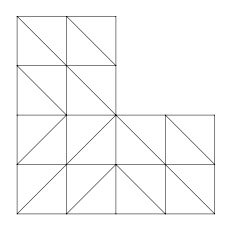

In [85]:
m = MeshTri().init_lshaped()
m.refine()
draw(m)

In [86]:
uh0 = np.zeros(basis['u'].N)

In [91]:
uh0[boundary_dofs] = project(dirichlet, basis_to=boundary_basis, I=boundary_dofs)

C:\Users\ASUS\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [29]:
epsilon = 0
ep = epsilon

In [89]:
K2.todense()

matrix([[1.5       , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.08333333, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.08333333,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.08333333]])

In [81]:
f2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [90]:
uh0

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,
        0.,  0., nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,
        0.,  0., nan, nan, nan, nan,  0., nan, nan,  0., nan, nan,  0.,
       nan, nan,  0., nan, nan,  0., nan, nan,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [88]:
condense(K2, f2, uh0, D=boundary_dofs)

(<33x33 sparse matrix of type '<class 'numpy.float64'>'
 	with 213 stored elements in Compressed Sparse Row format>,
 array([nan, nan, nan, nan, nan,  0.,  0., nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,
         0.,  0., nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,
         0.,  0., nan, nan, nan, nan,  0., nan, nan,  0., nan, nan,  0.,
        nan, nan,  0., nan, nan,  0., nan, nan,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([10, 11, 12, 13, 14, 23, 24, 25, 26, 27, 32, 35, 38, 41, 44, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]))

In [ ]:
uh0, boundary_dofs

In [45]:
uh0, basis = solve_problem1(m, element_type, solver_type, intorder, tol, epsilon)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\ASUS\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\skfem\utils.py:307: UserWarning: Convergence not achieved!
  warnings.warn("Convergence not achieved!")


In [25]:
uh0

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [ ]:
time_start = time.time()

print('=======Arguments=======')
print('penalty:\t{}'.format(penalty))
print('element_type:\t{}'.format(element_type))
print('solver_type:\t{}'.format(solver_type))
print('tol:\t{}'.format(tol))
print('intorder:\t{}'.format(intorder))
print('refine_time:\t{}'.format(refine_time))
print('sigma:\t{}'.format(sigma))
print('=======Results=======')

df_list = []
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri().init_lshaped()
#     draw(m)

    for i in range(1, refine_time+1):
        
        m.refine()
        
        if penalty:
            uh0, basis, fbasis = solve_problem2(m, element_type, solver_type, intorder, tol, epsilon)
        else:
            uh0, basis = solve_problem1(m, element_type, solver_type, intorder, tol, epsilon)

        U = basis['u'].interpolate(uh0).value

        # compute errors

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        if penalty:
            D2u = np.sqrt(get_D2uError(basis['u'], uh0)**2 + L2pnvError.assemble(fbasis, w=fbasis.interpolate(uh0)))
        else:
            D2u = get_D2uError(basis['u'], uh0)
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    
    # store data
    data = np.array([L2s, H1s, H2s, epus])
    df = pd.DataFrame(data.T, columns=['L2', 'H1', 'H2', 'Energy'])
    df_list.append(df)
    
    print('epsilion:', epsilon)
    show_result(L2s, H1s, H2s, epus)

time_end = time.time()

result = df_list[0].append(df_list[1:])
result.to_csv(save_path+'.csv')
print('======= Errors saved in:', save_path+'.csv ==========')
print('Total Time Cost {:.2f} s'.format(time_end-time_start))